In [19]:
# import modules
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.tree import DecisionTreeRegressor
warnings.filterwarnings('ignore')

## Data Precprocessing 

In [2]:
# assign path
path, dirs, files = next(os.walk('../data/csv'))
file_count = len(files)

# create empty list
dataframes_list = []
# append datasets to the list 
for i in range(file_count):
    temp_df = pd.read_csv(path+'/'+files[i])
    temp_df = temp_df.drop(columns='year')
    
    # Assign a unique pollutant number to each dataset
    # The value of 'i+1' ensures that each dataset is assigned a unique number starting from 1
    temp_df.insert(2, 'Pollutant', i+1) # 
    dataframes_list.append(temp_df)

# Concatenate dataframes into one signle dataframe
df = pd.concat(dataframes_list, ignore_index= True)    

In [3]:
# Standardizing Data
scaler = StandardScaler()

# Apply StandardScaler to each column except the third one (index 2)
for col in df.columns:
    if df.columns.get_loc(col) != 2:  # Checks if the column index is not 2
        df[col] = scaler.fit_transform(df[[col]])   

In [4]:
df.isnull().sum()

x            0
y            0
Pollutant    0
conct        0
dtype: int64

## Data Exploration/Visualization

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29282140 entries, 0 to 29282139
Data columns (total 4 columns):
 #   Column     Dtype  
---  ------     -----  
 0   x          float64
 1   y          float64
 2   Pollutant  int64  
 3   conct      float64
dtypes: float64(3), int64(1)
memory usage: 893.6 MB


In [6]:
df.describe()

,x,y,Pollutant,conct
count,2.928214e+07,2.928214e+07,2.928214e+07,2.928214e+07
mean,3.704553e-15,-1.224374e-16,3.000000e+00,3.682128e-16
std,1.000000e+00,1.000000e+00,1.414214e+00,1.000000e+00
min,-1.878738e+00,-2.028950e+00,1.000000e+00,-1.123693e+00
25%,-8.421617e-01,-8.240802e-01,2.000000e+00,-6.046423e-01
50%,-3.992524e-03,3.078914e-02,3.000000e+00,-1.303285e-01
75%,8.341766e-01,8.391981e-01,4.000000e+00,3.145508e-01
max,2.205481e+00,1.927918e+00,5.000000e+00,5.150201e+02


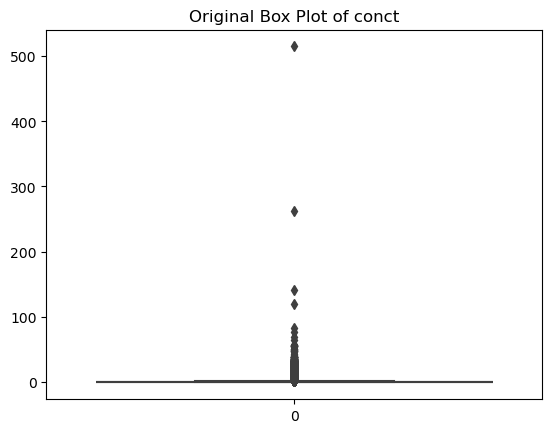

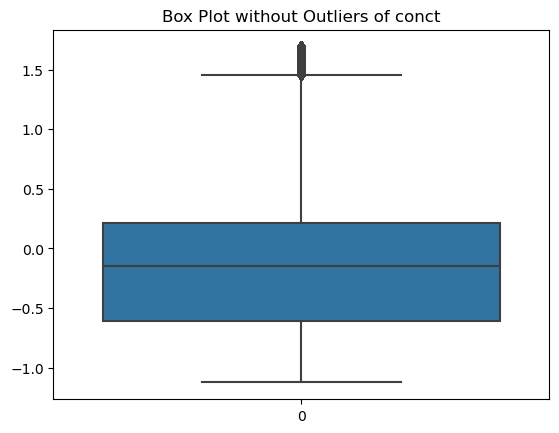

In [7]:
def remove_outliers(df, column):
    sns.boxplot(df[column])
    plt.title(f'Original Box Plot of {column}')
    plt.show()

    
    for x in [column]:
        q75,q25 = np.percentile(df.loc[:,x],[75,25])
        intr_qr = q75-q25
 
        max = q75+(1.5*intr_qr)
        min = q25-(1.5*intr_qr)
 
        df.loc[df[x] < min,x] = np.nan
        df.loc[df[x] > max,x] = np.nan
    
    df[column].isnull().sum()
    df = df.dropna()
 
    sns.boxplot(df[column])
    plt.title(f'Box Plot without Outliers of {column}')
    plt.show()
    return df
 
df = remove_outliers(df, 'conct')

In [9]:
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot = True, cmap = 'viridis', 
            fmt = '0.2f', linewidth = 0.5)
plt.title('Correlation Heatmap')
plt.xlabel('Features')
plt.ylabel('Features')
plt.xticks(rotation = 45)
plt.show()

In [10]:
# 3D visulaisation
fig = plt.figure(figsize = (20,20))
plt.style.use('classic')
ax = fig.add_subplot(111, projection='3d')
ax.scatter(df['x'], df['y'],df['conct'], c = 'red')
ax.set_xlabel('x', fontsize = 20)
ax.set_ylabel('y', fontsize = 20)
ax.set_zlabel('conct', fontsize = 20)

## Regression Models

In [11]:
X = df.drop(columns='conct').values  #features
y = df['conct']  # Target variable

In [12]:
# using the train test split function 
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=104, test_size=0.25, shuffle=True) 

In [20]:
# Function to evaluate the performance of different models
def evaluate(model, X_train, X_test, y_train, y_test):
    y_test_pred = model.predict(X_test)
    y_train_pred = model.predict(X_train)

# Evaluation metrics
    print('TRAINING RESULTS FOR {model}: \n===============================')
    print(f'Mean Absolute Error (MAE) - Training: {mean_absolute_error(y_train, y_train_pred):.4f}')
    print(f'Mean Squared Error (MSE) - Training: {mean_squared_error(y_train, y_train_pred):.4f}')
    print(f'R-squared (R²) Score - Training: {r2_score(y_train, y_train_pred):.4f}')

    print('\nTESTING RESULTS FOR {model}: \n===============================')
    print(f'Mean Absolute Error (MAE) - Testing: {mean_absolute_error(y_test, y_test_pred):.4f}')
    print(f'Mean Squared Error (MSE) - Testing: {mean_squared_error(y_test, y_test_pred):.4f}')
    print(f'R-squared (R²) Score - Testing: {r2_score(y_test, y_test_pred):.4f}')

#### ** Model 1: Decision Tree

In [14]:
model1 =DecisionTreeRegressor()
model1.fit(X_train, y_train)
model1.predict(X_test)
evaluate(model1, X_train, X_test, y_train, y_test)

### Ensemble Methods
#### ** Model 2: BaggingRegressor **

In [ ]:
# Create a DecisionTreeRegressor as the base estimator
tree = DecisionTreeRegressor()
# Create a BaggingRegressor ensemble model using DecisionTreeRegressor as the base estimator
model2 = BaggingRegressor(base_estimator=tree, n_estimators=10, random_state=42)
model2.fit(X_train, y_train)
evaluate(model2, X_train, X_test, y_train, y_test)

#### ** Model 3: Random Forest Reggressor **

In [ ]:
# Fitting Random Forest Regression to the dataset
model3 = RandomForestRegressor(n_estimators=10, random_state=0, oob_score=True)
# Fit the regressor with x and y data
model3.fit(X_train, y_train)
evaluate(model3, X_train, X_test, y_train, y_test)